<a href="https://colab.research.google.com/github/DariusTheGeek/Radiant-Earth-Spot-the-Crop-Challenge/blob/main/Brainiac_Feature_Engineering_%26_CATBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Oct  8 06:16:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip -qq install catboost

     |████████████████████████████████| 76.4 MB 42 kB/s 


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from functools import reduce
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Month Start End Data
!gdown --id 1-3eSgP9jRK3n5JATtd62h0LNnQwOluqv
!gdown --id 1-6d5EMxlg44amERHerYSuVkXCiUFu-kM

# Season Data
!gdown --id 1-955Isi3nJAUd0v7RWohj9zPFhsM4Rvi
!gdown --id 1-7of-3JVM1PII3JMHM7kQQE4ebjGShDm

Downloading...
From: https://drive.google.com/uc?id=1-3eSgP9jRK3n5JATtd62h0LNnQwOluqv
To: /content/month_start_end_train.csv
100% 289M/289M [00:01<00:00, 220MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6d5EMxlg44amERHerYSuVkXCiUFu-kM
To: /content/month_start_end_test.csv
100% 118M/118M [00:00<00:00, 208MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-955Isi3nJAUd0v7RWohj9zPFhsM4Rvi
To: /content/season_train.csv
100% 458M/458M [00:02<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-7of-3JVM1PII3JMHM7kQQE4ebjGShDm
To: /content/season_test.csv
100% 186M/186M [00:00<00:00, 215MB/s]


In [5]:
month_start_end_train = pd.read_csv('month_start_end_train.csv').sort_values(by = 'field').reset_index(drop = True)
month_start_end_test = pd.read_csv('month_start_end_test.csv').sort_values(by = 'field').reset_index(drop = True)
season_train = pd.read_csv('season_train.csv').sort_values(by = 'field').reset_index(drop = True)
season_test = pd.read_csv('season_test.csv').sort_values(by = 'field').reset_index(drop = True)
season_train.head()

,B01_PERIOD_0,B02_PERIOD_0,B03_PERIOD_0,B04_PERIOD_0,B05_PERIOD_0,B06_PERIOD_0,B07_PERIOD_0,B08_PERIOD_0,B8A_PERIOD_0,B09_PERIOD_0,B11_PERIOD_0,B12_PERIOD_0,CLM_PERIOD_0,B01_PERIOD_1,B02_PERIOD_1,B03_PERIOD_1,B04_PERIOD_1,B05_PERIOD_1,B06_PERIOD_1,B07_PERIOD_1,B08_PERIOD_1,B8A_PERIOD_1,B09_PERIOD_1,B11_PERIOD_1,B12_PERIOD_1,CLM_PERIOD_1,B01_PERIOD_2,B02_PERIOD_2,B03_PERIOD_2,B04_PERIOD_2,B05_PERIOD_2,B06_PERIOD_2,B07_PERIOD_2,B08_PERIOD_2,B8A_PERIOD_2,B09_PERIOD_2,B11_PERIOD_2,B12_PERIOD_2,CLM_PERIOD_2,B01_PERIOD_3,B02_PERIOD_3,B03_PERIOD_3,B04_PERIOD_3,B05_PERIOD_3,B06_PERIOD_3,B07_PERIOD_3,B08_PERIOD_3,B8A_PERIOD_3,B09_PERIOD_3,B11_PERIOD_3,B12_PERIOD_3,CLM_PERIOD_3,B01_PERIOD_4,B02_PERIOD_4,B03_PERIOD_4,B04_PERIOD_4,B05_PERIOD_4,B06_PERIOD_4,B07_PERIOD_4,B08_PERIOD_4,B8A_PERIOD_4,B09_PERIOD_4,B11_PERIOD_4,B12_PERIOD_4,CLM_PERIOD_4,B01_PERIOD_5,B02_PERIOD_5,B03_PERIOD_5,B04_PERIOD_5,B05_PERIOD_5,B06_PERIOD_5,B07_PERIOD_5,B08_PERIOD_5,B8A_PERIOD_5,B09_PERIOD_5,B11_PERIOD_5,B12_PERIOD_5,CLM_PERIOD_5,B01_PERIOD_6,B02_PERIOD_6,B03_PERIOD_6,B04_PERIOD_6,B05_PERIOD_6,B06_PERIOD_6,B07_PERIOD_6,B08_PERIOD_6,B8A_PERIOD_6,B09_PERIOD_6,B11_PERIOD_6,B12_PERIOD_6,CLM_PERIOD_6,B01_PERIOD_7,B02_PERIOD_7,B03_PERIOD_7,B04_PERIOD_7,B05_PERIOD_7,B06_PERIOD_7,B07_PERIOD_7,B08_PERIOD_7,B8A_PERIOD_7,B09_PERIOD_7,B11_PERIOD_7,B12_PERIOD_7,CLM_PERIOD_7,B01_PERIOD_8,B02_PERIOD_8,B03_PERIOD_8,B04_PERIOD_8,B05_PERIOD_8,B06_PERIOD_8,B07_PERIOD_8,B08_PERIOD_8,B8A_PERIOD_8,B09_PERIOD_8,B11_PERIOD_8,B12_PERIOD_8,CLM_PERIOD_8,B01_PERIOD_9,B02_PERIOD_9,B03_PERIOD_9,B04_PERIOD_9,B05_PERIOD_9,B06_PERIOD_9,B07_PERIOD_9,B08_PERIOD_9,B8A_PERIOD_9,B09_PERIOD_9,B11_PERIOD_9,B12_PERIOD_9,CLM_PERIOD_9,B01_PERIOD_10,B02_PERIOD_10,B03_PERIOD_10,B04_PERIOD_10,B05_PERIOD_10,B06_PERIOD_10,B07_PERIOD_10,B08_PERIOD_10,B8A_PERIOD_10,B09_PERIOD_10,B11_PERIOD_10,B12_PERIOD_10,CLM_PERIOD_10,B01_PERIOD_11,B02_PERIOD_11,B03_PERIOD_11,B04_PERIOD_11,B05_PERIOD_11,B06_PERIOD_11,B07_PERIOD_11,B08_PERIOD_11,B8A_PERIOD_11,B09_PERIOD_11,B11_PERIOD_11,B12_PERIOD_11,CLM_PERIOD_11,B01_PERIOD_12,B02_PERIOD_12,B03_PERIOD_12,B04_PERIOD_12,B05_PERIOD_12,B06_PERIOD_12,B07_PERIOD_12,B08_PERIOD_12,B8A_PERIOD_12,B09_PERIOD_12,B11_PERIOD_12,B12_PERIOD_12,CLM_PERIOD_12,B01_PERIOD_13,B02_PERIOD_13,B03_PERIOD_13,B04_PERIOD_13,B05_PERIOD_13,B06_PERIOD_13,B07_PERIOD_13,B08_PERIOD_13,B8A_PERIOD_13,B09_PERIOD_13,B11_PERIOD_13,B12_PERIOD_13,CLM_PERIOD_13,B01_PERIOD_14,B02_PERIOD_14,B03_PERIOD_14,B04_PERIOD_14,B05_PERIOD_14,B06_PERIOD_14,B07_PERIOD_14,B08_PERIOD_14,B8A_PERIOD_14,B09_PERIOD_14,B11_PERIOD_14,B12_PERIOD_14,CLM_PERIOD_14,B01_PERIOD_15,B02_PERIOD_15,B03_PERIOD_15,B04_PERIOD_15,B05_PERIOD_15,B06_PERIOD_15,B07_PERIOD_15,B08_PERIOD_15,B8A_PERIOD_15,B09_PERIOD_15,B11_PERIOD_15,B12_PERIOD_15,CLM_PERIOD_15,B01_PERIOD_16,B02_PERIOD_16,B03_PERIOD_16,B04_PERIOD_16,B05_PERIOD_16,B06_PERIOD_16,B07_PERIOD_16,B08_PERIOD_16,B8A_PERIOD_16,B09_PERIOD_16,B11_PERIOD_16,B12_PERIOD_16,CLM_PERIOD_16,B01_PERIOD_17,B02_PERIOD_17,B03_PERIOD_17,B04_PERIOD_17,B05_PERIOD_17,B06_PERIOD_17,B07_PERIOD_17,B08_PERIOD_17,B8A_PERIOD_17,B09_PERIOD_17,B11_PERIOD_17,B12_PERIOD_17,CLM_PERIOD_17,B01_PERIOD_18,B02_PERIOD_18,B03_PERIOD_18,B04_PERIOD_18,B05_PERIOD_18,B06_PERIOD_18,B07_PERIOD_18,B08_PERIOD_18,B8A_PERIOD_18,B09_PERIOD_18,B11_PERIOD_18,B12_PERIOD_18,CLM_PERIOD_18,B01_PERIOD_19,B02_PERIOD_19,B03_PERIOD_19,B04_PERIOD_19,B05_PERIOD_19,B06_PERIOD_19,B07_PERIOD_19,B08_PERIOD_19,B8A_PERIOD_19,B09_PERIOD_19,B11_PERIOD_19,B12_PERIOD_19,CLM_PERIOD_19,B01_PERIOD_20,B02_PERIOD_20,B03_PERIOD_20,B04_PERIOD_20,B05_PERIOD_20,B06_PERIOD_20,B07_PERIOD_20,B08_PERIOD_20,B8A_PERIOD_20,B09_PERIOD_20,B11_PERIOD_20,B12_PERIOD_20,CLM_PERIOD_20,B01_PERIOD_21,B02_PERIOD_21,B03_PERIOD_21,B04_PERIOD_21,B05_PERIOD_21,B06_PERIOD_21,B07_PERIOD_21,B08_PERIOD_21,B8A_PERIOD_21,B09_PERIOD_21,B11_PERIOD_21,B12_PERIOD_21,CLM_PERIOD_21,B01_PERIOD_22,B02_PERIOD_22,B03_PERIOD_22,B04_PERIOD_22,B05_PERIOD_22,B06_PERIOD_22,B07_PERIOD_22,B08_PERIOD_22,B8A_PERIOD_22

In [6]:
month_start_end_train.head()

,B01_APR_START,B02_APR_START,B03_APR_START,B04_APR_START,B05_APR_START,B06_APR_START,B07_APR_START,B08_APR_START,B8A_APR_START,B09_APR_START,B11_APR_START,B12_APR_START,CLM_APR_START,B01_APR_END,B02_APR_END,B03_APR_END,B04_APR_END,B05_APR_END,B06_APR_END,B07_APR_END,B08_APR_END,B8A_APR_END,B09_APR_END,B11_APR_END,B12_APR_END,CLM_APR_END,B01_MAY_START,B02_MAY_START,B03_MAY_START,B04_MAY_START,B05_MAY_START,B06_MAY_START,B07_MAY_START,B08_MAY_START,B8A_MAY_START,B09_MAY_START,B11_MAY_START,B12_MAY_START,CLM_MAY_START,B01_MAY_END,B02_MAY_END,B03_MAY_END,B04_MAY_END,B05_MAY_END,B06_MAY_END,B07_MAY_END,B08_MAY_END,B8A_MAY_END,B09_MAY_END,B11_MAY_END,B12_MAY_END,CLM_MAY_END,B01_JUN_START,B02_JUN_START,B03_JUN_START,B04_JUN_START,B05_JUN_START,B06_JUN_START,B07_JUN_START,B08_JUN_START,B8A_JUN_START,B09_JUN_START,B11_JUN_START,B12_JUN_START,CLM_JUN_START,B01_JUN_END,B02_JUN_END,B03_JUN_END,B04_JUN_END,B05_JUN_END,B06_JUN_END,B07_JUN_END,B08_JUN_END,B8A_JUN_END,B09_JUN_END,B11_JUN_END,B12_JUN_END,CLM_JUN_END,B01_JUL_START,B02_JUL_START,B03_JUL_START,B04_JUL_START,B05_JUL_START,B06_JUL_START,B07_JUL_START,B08_JUL_START,B8A_JUL_START,B09_JUL_START,B11_JUL_START,B12_JUL_START,CLM_JUL_START,B01_JUL_END,B02_JUL_END,B03_JUL_END,B04_JUL_END,B05_JUL_END,B06_JUL_END,B07_JUL_END,B08_JUL_END,B8A_JUL_END,B09_JUL_END,B11_JUL_END,B12_JUL_END,CLM_JUL_END,B01_AUG_START,B02_AUG_START,B03_AUG_START,B04_AUG_START,B05_AUG_START,B06_AUG_START,B07_AUG_START,B08_AUG_START,B8A_AUG_START,B09_AUG_START,B11_AUG_START,B12_AUG_START,CLM_AUG_START,B01_AUG_END,B02_AUG_END,B03_AUG_END,B04_AUG_END,B05_AUG_END,B06_AUG_END,B07_AUG_END,B08_AUG_END,B8A_AUG_END,B09_AUG_END,B11_AUG_END,B12_AUG_END,CLM_AUG_END,B01_SEPT_START,B02_SEPT_START,B03_SEPT_START,B04_SEPT_START,B05_SEPT_START,B06_SEPT_START,B07_SEPT_START,B08_SEPT_START,B8A_SEPT_START,B09_SEPT_START,B11_SEPT_START,B12_SEPT_START,CLM_SEPT_START,B01_SEPT_END,B02_SEPT_END,B03_SEPT_END,B04_SEPT_END,B05_SEPT_END,B06_SEPT_END,B07_SEPT_END,B08_SEPT_END,B8A_SEPT_END,B09_SEPT_END,B11_SEPT_END,B12_SEPT_END,CLM_SEPT_END,B01_OCT_START,B02_OCT_START,B03_OCT_START,B04_OCT_START,B05_OCT_START,B06_OCT_START,B07_OCT_START,B08_OCT_START,B8A_OCT_START,B09_OCT_START,B11_OCT_START,B12_OCT_START,CLM_OCT_START,B01_OCT_END,B02_OCT_END,B03_OCT_END,B04_OCT_END,B05_OCT_END,B06_OCT_END,B07_OCT_END,B08_OCT_END,B8A_OCT_END,B09_OCT_END,B11_OCT_END,B12_OCT_END,CLM_OCT_END,B01_NOV_START,B02_NOV_START,B03_NOV_START,B04_NOV_START,B05_NOV_START,B06_NOV_START,B07_NOV_START,B08_NOV_START,B8A_NOV_START,B09_NOV_START,B11_NOV_START,B12_NOV_START,CLM_NOV_START,B01_NOV_END,B02_NOV_END,B03_NOV_END,B04_NOV_END,B05_NOV_END,B06_NOV_END,B07_NOV_END,B08_NOV_END,B8A_NOV_END,B09_NOV_END,B11_NOV_END,B12_NOV_END,CLM_NOV_END,y,field
0,18.154341,21.934084,29.180064,35.554662,43.747588,52.438907,57.289389,62.490354,63.221865,64.434084,68.397106,46.040193,253.770096,10.823151,13.385852,21.596463,29.223473,37.771704,46.858521,51.930868,57.065916,59.025723,59.684887,73.668810,49.313505,0.0,13.963023,15.408360,22.471061,29.371383,38.829582,47.680064,52.982315,56.434084,60.509646,60.676849,71.057878,46.557878,36.897106,15.144695,15.813505,23.000000,30.237942,37.426045,41.763666,45.440514,48.397106,51.731511,51.991961,79.366559,58.991961,0.0,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,254.704180,255.000000,132.663987,111.138264,255.0,189.729904,166.000000,156.102894,150.096463,155.239550,150.897106,149.454984,148.377814,148.676849,152.442122,97.961415,65.845659,255.0,3.988746,9.366559,15.840836,15.077170,25.808682,42.319936,46.670418,51.408360,50.348875,50.612540,50.265273,32.673633,0.0,8.366559,9.265273,18.598071,14.300643,30.691318,63.106109,69.946945,73.424437,73.975884,73.988746,56.532154,32.744373,0.0,4.564309,8.829582,16.622186,11.213826,27.863344,64.485531,72.945338,75.901929,76.004823,76.848875,52.750804,30.342444,0.0,247.141479,230.686495,228.647910,228.053055,232.638264,227.472669,225.821543,228.831190,222.315113,233.003215,

# Feature Engineering for Season

## Combine train and test datasets for easy manipulation

In [8]:
# Combining training and test data for easy manipulation
train_df, test_df, target_season = season_train.copy(), season_test.copy(), season_train.y.copy()
splitter = train_df.shape[0]
comb = pd.concat([train_df, test_df], join = 'inner')
comb.drop('field', axis = 1, inplace = True)
comb.head()

,B01_PERIOD_0,B02_PERIOD_0,B03_PERIOD_0,B04_PERIOD_0,B05_PERIOD_0,B06_PERIOD_0,B07_PERIOD_0,B08_PERIOD_0,B8A_PERIOD_0,B09_PERIOD_0,B11_PERIOD_0,B12_PERIOD_0,CLM_PERIOD_0,B01_PERIOD_1,B02_PERIOD_1,B03_PERIOD_1,B04_PERIOD_1,B05_PERIOD_1,B06_PERIOD_1,B07_PERIOD_1,B08_PERIOD_1,B8A_PERIOD_1,B09_PERIOD_1,B11_PERIOD_1,B12_PERIOD_1,CLM_PERIOD_1,B01_PERIOD_2,B02_PERIOD_2,B03_PERIOD_2,B04_PERIOD_2,B05_PERIOD_2,B06_PERIOD_2,B07_PERIOD_2,B08_PERIOD_2,B8A_PERIOD_2,B09_PERIOD_2,B11_PERIOD_2,B12_PERIOD_2,CLM_PERIOD_2,B01_PERIOD_3,B02_PERIOD_3,B03_PERIOD_3,B04_PERIOD_3,B05_PERIOD_3,B06_PERIOD_3,B07_PERIOD_3,B08_PERIOD_3,B8A_PERIOD_3,B09_PERIOD_3,B11_PERIOD_3,B12_PERIOD_3,CLM_PERIOD_3,B01_PERIOD_4,B02_PERIOD_4,B03_PERIOD_4,B04_PERIOD_4,B05_PERIOD_4,B06_PERIOD_4,B07_PERIOD_4,B08_PERIOD_4,B8A_PERIOD_4,B09_PERIOD_4,B11_PERIOD_4,B12_PERIOD_4,CLM_PERIOD_4,B01_PERIOD_5,B02_PERIOD_5,B03_PERIOD_5,B04_PERIOD_5,B05_PERIOD_5,B06_PERIOD_5,B07_PERIOD_5,B08_PERIOD_5,B8A_PERIOD_5,B09_PERIOD_5,B11_PERIOD_5,B12_PERIOD_5,CLM_PERIOD_5,B01_PERIOD_6,B02_PERIOD_6,B03_PERIOD_6,B04_PERIOD_6,B05_PERIOD_6,B06_PERIOD_6,B07_PERIOD_6,B08_PERIOD_6,B8A_PERIOD_6,B09_PERIOD_6,B11_PERIOD_6,B12_PERIOD_6,CLM_PERIOD_6,B01_PERIOD_7,B02_PERIOD_7,B03_PERIOD_7,B04_PERIOD_7,B05_PERIOD_7,B06_PERIOD_7,B07_PERIOD_7,B08_PERIOD_7,B8A_PERIOD_7,B09_PERIOD_7,B11_PERIOD_7,B12_PERIOD_7,CLM_PERIOD_7,B01_PERIOD_8,B02_PERIOD_8,B03_PERIOD_8,B04_PERIOD_8,B05_PERIOD_8,B06_PERIOD_8,B07_PERIOD_8,B08_PERIOD_8,B8A_PERIOD_8,B09_PERIOD_8,B11_PERIOD_8,B12_PERIOD_8,CLM_PERIOD_8,B01_PERIOD_9,B02_PERIOD_9,B03_PERIOD_9,B04_PERIOD_9,B05_PERIOD_9,B06_PERIOD_9,B07_PERIOD_9,B08_PERIOD_9,B8A_PERIOD_9,B09_PERIOD_9,B11_PERIOD_9,B12_PERIOD_9,CLM_PERIOD_9,B01_PERIOD_10,B02_PERIOD_10,B03_PERIOD_10,B04_PERIOD_10,B05_PERIOD_10,B06_PERIOD_10,B07_PERIOD_10,B08_PERIOD_10,B8A_PERIOD_10,B09_PERIOD_10,B11_PERIOD_10,B12_PERIOD_10,CLM_PERIOD_10,B01_PERIOD_11,B02_PERIOD_11,B03_PERIOD_11,B04_PERIOD_11,B05_PERIOD_11,B06_PERIOD_11,B07_PERIOD_11,B08_PERIOD_11,B8A_PERIOD_11,B09_PERIOD_11,B11_PERIOD_11,B12_PERIOD_11,CLM_PERIOD_11,B01_PERIOD_12,B02_PERIOD_12,B03_PERIOD_12,B04_PERIOD_12,B05_PERIOD_12,B06_PERIOD_12,B07_PERIOD_12,B08_PERIOD_12,B8A_PERIOD_12,B09_PERIOD_12,B11_PERIOD_12,B12_PERIOD_12,CLM_PERIOD_12,B01_PERIOD_13,B02_PERIOD_13,B03_PERIOD_13,B04_PERIOD_13,B05_PERIOD_13,B06_PERIOD_13,B07_PERIOD_13,B08_PERIOD_13,B8A_PERIOD_13,B09_PERIOD_13,B11_PERIOD_13,B12_PERIOD_13,CLM_PERIOD_13,B01_PERIOD_14,B02_PERIOD_14,B03_PERIOD_14,B04_PERIOD_14,B05_PERIOD_14,B06_PERIOD_14,B07_PERIOD_14,B08_PERIOD_14,B8A_PERIOD_14,B09_PERIOD_14,B11_PERIOD_14,B12_PERIOD_14,CLM_PERIOD_14,B01_PERIOD_15,B02_PERIOD_15,B03_PERIOD_15,B04_PERIOD_15,B05_PERIOD_15,B06_PERIOD_15,B07_PERIOD_15,B08_PERIOD_15,B8A_PERIOD_15,B09_PERIOD_15,B11_PERIOD_15,B12_PERIOD_15,CLM_PERIOD_15,B01_PERIOD_16,B02_PERIOD_16,B03_PERIOD_16,B04_PERIOD_16,B05_PERIOD_16,B06_PERIOD_16,B07_PERIOD_16,B08_PERIOD_16,B8A_PERIOD_16,B09_PERIOD_16,B11_PERIOD_16,B12_PERIOD_16,CLM_PERIOD_16,B01_PERIOD_17,B02_PERIOD_17,B03_PERIOD_17,B04_PERIOD_17,B05_PERIOD_17,B06_PERIOD_17,B07_PERIOD_17,B08_PERIOD_17,B8A_PERIOD_17,B09_PERIOD_17,B11_PERIOD_17,B12_PERIOD_17,CLM_PERIOD_17,B01_PERIOD_18,B02_PERIOD_18,B03_PERIOD_18,B04_PERIOD_18,B05_PERIOD_18,B06_PERIOD_18,B07_PERIOD_18,B08_PERIOD_18,B8A_PERIOD_18,B09_PERIOD_18,B11_PERIOD_18,B12_PERIOD_18,CLM_PERIOD_18,B01_PERIOD_19,B02_PERIOD_19,B03_PERIOD_19,B04_PERIOD_19,B05_PERIOD_19,B06_PERIOD_19,B07_PERIOD_19,B08_PERIOD_19,B8A_PERIOD_19,B09_PERIOD_19,B11_PERIOD_19,B12_PERIOD_19,CLM_PERIOD_19,B01_PERIOD_20,B02_PERIOD_20,B03_PERIOD_20,B04_PERIOD_20,B05_PERIOD_20,B06_PERIOD_20,B07_PERIOD_20,B08_PERIOD_20,B8A_PERIOD_20,B09_PERIOD_20,B11_PERIOD_20,B12_PERIOD_20,CLM_PERIOD_20,B01_PERIOD_21,B02_PERIOD_21,B03_PERIOD_21,B04_PERIOD_21,B05_PERIOD_21,B06_PERIOD_21,B07_PERIOD_21,B08_PERIOD_21,B8A_PERIOD_21,B09_PERIOD_21,B11_PERIOD_21,B12_PERIOD_21,CLM_PERIOD_21,B01_PERIOD_22,B02_PERIOD_22,B03_PERIOD_22,B04_PERIOD_22,B05_PERIOD_22,B06_PERIOD_22,B07_PERIOD_22,B08_PERIOD_22,B8A_PERIOD_22

## Remove Skewness

In [9]:
# Remove skewness by using square root
comb = comb**(1/2.0)
comb.head()

,B01_PERIOD_0,B02_PERIOD_0,B03_PERIOD_0,B04_PERIOD_0,B05_PERIOD_0,B06_PERIOD_0,B07_PERIOD_0,B08_PERIOD_0,B8A_PERIOD_0,B09_PERIOD_0,B11_PERIOD_0,B12_PERIOD_0,CLM_PERIOD_0,B01_PERIOD_1,B02_PERIOD_1,B03_PERIOD_1,B04_PERIOD_1,B05_PERIOD_1,B06_PERIOD_1,B07_PERIOD_1,B08_PERIOD_1,B8A_PERIOD_1,B09_PERIOD_1,B11_PERIOD_1,B12_PERIOD_1,CLM_PERIOD_1,B01_PERIOD_2,B02_PERIOD_2,B03_PERIOD_2,B04_PERIOD_2,B05_PERIOD_2,B06_PERIOD_2,B07_PERIOD_2,B08_PERIOD_2,B8A_PERIOD_2,B09_PERIOD_2,B11_PERIOD_2,B12_PERIOD_2,CLM_PERIOD_2,B01_PERIOD_3,B02_PERIOD_3,B03_PERIOD_3,B04_PERIOD_3,B05_PERIOD_3,B06_PERIOD_3,B07_PERIOD_3,B08_PERIOD_3,B8A_PERIOD_3,B09_PERIOD_3,B11_PERIOD_3,B12_PERIOD_3,CLM_PERIOD_3,B01_PERIOD_4,B02_PERIOD_4,B03_PERIOD_4,B04_PERIOD_4,B05_PERIOD_4,B06_PERIOD_4,B07_PERIOD_4,B08_PERIOD_4,B8A_PERIOD_4,B09_PERIOD_4,B11_PERIOD_4,B12_PERIOD_4,CLM_PERIOD_4,B01_PERIOD_5,B02_PERIOD_5,B03_PERIOD_5,B04_PERIOD_5,B05_PERIOD_5,B06_PERIOD_5,B07_PERIOD_5,B08_PERIOD_5,B8A_PERIOD_5,B09_PERIOD_5,B11_PERIOD_5,B12_PERIOD_5,CLM_PERIOD_5,B01_PERIOD_6,B02_PERIOD_6,B03_PERIOD_6,B04_PERIOD_6,B05_PERIOD_6,B06_PERIOD_6,B07_PERIOD_6,B08_PERIOD_6,B8A_PERIOD_6,B09_PERIOD_6,B11_PERIOD_6,B12_PERIOD_6,CLM_PERIOD_6,B01_PERIOD_7,B02_PERIOD_7,B03_PERIOD_7,B04_PERIOD_7,B05_PERIOD_7,B06_PERIOD_7,B07_PERIOD_7,B08_PERIOD_7,B8A_PERIOD_7,B09_PERIOD_7,B11_PERIOD_7,B12_PERIOD_7,CLM_PERIOD_7,B01_PERIOD_8,B02_PERIOD_8,B03_PERIOD_8,B04_PERIOD_8,B05_PERIOD_8,B06_PERIOD_8,B07_PERIOD_8,B08_PERIOD_8,B8A_PERIOD_8,B09_PERIOD_8,B11_PERIOD_8,B12_PERIOD_8,CLM_PERIOD_8,B01_PERIOD_9,B02_PERIOD_9,B03_PERIOD_9,B04_PERIOD_9,B05_PERIOD_9,B06_PERIOD_9,B07_PERIOD_9,B08_PERIOD_9,B8A_PERIOD_9,B09_PERIOD_9,B11_PERIOD_9,B12_PERIOD_9,CLM_PERIOD_9,B01_PERIOD_10,B02_PERIOD_10,B03_PERIOD_10,B04_PERIOD_10,B05_PERIOD_10,B06_PERIOD_10,B07_PERIOD_10,B08_PERIOD_10,B8A_PERIOD_10,B09_PERIOD_10,B11_PERIOD_10,B12_PERIOD_10,CLM_PERIOD_10,B01_PERIOD_11,B02_PERIOD_11,B03_PERIOD_11,B04_PERIOD_11,B05_PERIOD_11,B06_PERIOD_11,B07_PERIOD_11,B08_PERIOD_11,B8A_PERIOD_11,B09_PERIOD_11,B11_PERIOD_11,B12_PERIOD_11,CLM_PERIOD_11,B01_PERIOD_12,B02_PERIOD_12,B03_PERIOD_12,B04_PERIOD_12,B05_PERIOD_12,B06_PERIOD_12,B07_PERIOD_12,B08_PERIOD_12,B8A_PERIOD_12,B09_PERIOD_12,B11_PERIOD_12,B12_PERIOD_12,CLM_PERIOD_12,B01_PERIOD_13,B02_PERIOD_13,B03_PERIOD_13,B04_PERIOD_13,B05_PERIOD_13,B06_PERIOD_13,B07_PERIOD_13,B08_PERIOD_13,B8A_PERIOD_13,B09_PERIOD_13,B11_PERIOD_13,B12_PERIOD_13,CLM_PERIOD_13,B01_PERIOD_14,B02_PERIOD_14,B03_PERIOD_14,B04_PERIOD_14,B05_PERIOD_14,B06_PERIOD_14,B07_PERIOD_14,B08_PERIOD_14,B8A_PERIOD_14,B09_PERIOD_14,B11_PERIOD_14,B12_PERIOD_14,CLM_PERIOD_14,B01_PERIOD_15,B02_PERIOD_15,B03_PERIOD_15,B04_PERIOD_15,B05_PERIOD_15,B06_PERIOD_15,B07_PERIOD_15,B08_PERIOD_15,B8A_PERIOD_15,B09_PERIOD_15,B11_PERIOD_15,B12_PERIOD_15,CLM_PERIOD_15,B01_PERIOD_16,B02_PERIOD_16,B03_PERIOD_16,B04_PERIOD_16,B05_PERIOD_16,B06_PERIOD_16,B07_PERIOD_16,B08_PERIOD_16,B8A_PERIOD_16,B09_PERIOD_16,B11_PERIOD_16,B12_PERIOD_16,CLM_PERIOD_16,B01_PERIOD_17,B02_PERIOD_17,B03_PERIOD_17,B04_PERIOD_17,B05_PERIOD_17,B06_PERIOD_17,B07_PERIOD_17,B08_PERIOD_17,B8A_PERIOD_17,B09_PERIOD_17,B11_PERIOD_17,B12_PERIOD_17,CLM_PERIOD_17,B01_PERIOD_18,B02_PERIOD_18,B03_PERIOD_18,B04_PERIOD_18,B05_PERIOD_18,B06_PERIOD_18,B07_PERIOD_18,B08_PERIOD_18,B8A_PERIOD_18,B09_PERIOD_18,B11_PERIOD_18,B12_PERIOD_18,CLM_PERIOD_18,B01_PERIOD_19,B02_PERIOD_19,B03_PERIOD_19,B04_PERIOD_19,B05_PERIOD_19,B06_PERIOD_19,B07_PERIOD_19,B08_PERIOD_19,B8A_PERIOD_19,B09_PERIOD_19,B11_PERIOD_19,B12_PERIOD_19,CLM_PERIOD_19,B01_PERIOD_20,B02_PERIOD_20,B03_PERIOD_20,B04_PERIOD_20,B05_PERIOD_20,B06_PERIOD_20,B07_PERIOD_20,B08_PERIOD_20,B8A_PERIOD_20,B09_PERIOD_20,B11_PERIOD_20,B12_PERIOD_20,CLM_PERIOD_20,B01_PERIOD_21,B02_PERIOD_21,B03_PERIOD_21,B04_PERIOD_21,B05_PERIOD_21,B06_PERIOD_21,B07_PERIOD_21,B08_PERIOD_21,B8A_PERIOD_21,B09_PERIOD_21,B11_PERIOD_21,B12_PERIOD_21,CLM_PERIOD_21,B01_PERIOD_22,B02_PERIOD_22,B03_PERIOD_22,B04_PERIOD_22,B05_PERIOD_22,B06_PERIOD_22,B07_PERIOD_22,B08_PERIOD_22,B8A_PERIOD_22

## Vegetation Index Calculation

In [10]:
# Calculation of vegetation indices
def vegetation_index(i):
  b01 = comb.filter(like = "B01").values[:,i]
  b02 = comb.filter(like = "B02").values[:,i]
  b03 = comb.filter(like = "B03").values[:,i]
  b04 = comb.filter(like = "B04").values[:,i]
  b05 = comb.filter(like = "B05").values[:,i]
  b06 = comb.filter(like = "B06").values[:,i]
  b07 = comb.filter(like = "B07").values[:,i]
  b08 = comb.filter(like = "B08").values[:,i]
  b8a = comb.filter(like = "B8A").values[:,i]
  b09 = comb.filter(like = "B09").values[:,i]    
  b11 = comb.filter(like = "B11").values[:,i]
  b12 = comb.filter(like = "B12").values[:,i]

  # WHEAT
  MI = (b8a - b11) / (b8a + b11)
  ARVI =  (b08 - (2 * b04) + b02) / (b08 + (2 * b04) + b02)
  SIPI = (b08 - b02) / (b08 - b04)
  RENDVI = (b06 - b05) / (b06 + b05) 
  MRESR = (b06 - b01) / (b05 - b01)

  # CANOLA
  RYI = b03 / b02
  NDYI = (b03 - b02) / (b03 + b02)
  DYI = b03 - b02
  ACI = b08 * (b04 + b03)

  # WEED
  CVI = (b08 / b03) * (b04 / b03)
  AVI = (b08 * (1 - b04) * (b08 - b04))
  SI = ((1 - b02) * (1 - b03) * (1 - b04))
  BSI = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

  # SOIL
  SAVI = ((b08 - b04)/(b08 + b04 + 0.33)) * (1 + 0.33)

  # WINE GRAPES
  FIDET = b12 / (b8a * b09)
  MTCI = (b06 - b05)/(b05 - b04)
  NPCRI = (b04 - b02) / (b04 + b02)

  # GREENNESS
  S2REP = 705 + 35 * ((((b07 + b04)/2) - b05)/(b06 - b05)) 
  CCCI = ((b08 - b05) / (b08 + b05)) / ((b08 - b04) / (b08 + b04)) 
  MCARI = ((b05 - b04) - 2 * (b05 - b03)) * (b05 / b04)  
  TCARI = 3 * ((b05 - b04) - 0.2 * (b05 - b03) * (b05 / b04)) 
  PVI = (b08 - 0.3 * b04 - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 
  EVI = 2.5*(b08 - b04) / (b08 + 6*b04 - 7.5*b02 + 1) 
  NDVI = ((b08 - b04)/(b08 + b04))

  # ROOIBOS
  BAI = 1/((0.1 - b04) ** 2 + (0.06 - b08) ** 2)
  MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(b08, b03, b04))
  NDSI = (b03 - b11) / (b03 + b11)

  # RED EDGE
  MRENDVI = (b06 - b05) / (b06 + b05 - 2 * b01) 
  NDVIre = (b08 - b05)/(b08 + b05)
  CIre = ((b08 / b05) - 1)

  # DRYNESS / DROUGHT
  NDMI = (b08 - b11)/(b08 + b11) 
  TNDVI = [(x)**(1/2.0) for x in ((b08 - b04) / (b08 + b04) + 0.5)]

  # BASED ON THE VISIBLE SPECTRA REGION
  VDVI = (2 * b03 - b04 - b02) / (2 * b03 + b04  + b02) 

  # BURN
  NBR = (b08 - b11) / (b08+ b11) 

  # GENERAL
  TVI = (120 * (b06 - b03) - 200 * (b04 - b03)) / 2
  EXG = 2 * b03 - b04 - b02
  PSRI = (b04 - b02) / b06
  RDVI = [(i - j) / (i + j)**(1/2.0) for i, j in zip(b08, b04)]

  # COMMON BAND RATIOS
  RATIO1 = b01 / b03
  RATIO2 = b01 / b05
  RATIO3 = b11 / b12
  RATIO4 = b05 / b04

  return [MI, ARVI, SIPI, RENDVI, MRESR, RYI, NDYI, DYI, ACI, CVI, AVI, SI, BSI, SAVI, FIDET, MTCI, NPCRI, S2REP, CCCI,\
          MCARI, TCARI, PVI, EVI, NDVI, BAI, MTVI2, NDSI, MRENDVI, NDVIre, CIre, NDMI, TNDVI, VDVI, NBR, TVI, EXG, PSRI, RDVI, \
          RATIO1, RATIO2, RATIO3, RATIO4]

spectral_indices = ['MI', 'ARVI', 'SIPI', 'RENDVI', 'MRESR', 'RYI', 'NDYI', 'DYI', 'ACI', 'CVI', 'AVI', 'SI', 'BSI',\
                    'SAVI', 'FIDET', 'MTCI', 'NPCRI', 'S2REP', 'CCCI', 'MCARI', 'TCARI', 'PVI', 'EVI', 'NDVI', 'BAI', 'MTVI2', 'NDSI', 'MRENDVI',\
                    'NDVIre', 'CIre', 'NDMI', 'TNDVI', 'VDVI', 'NBR', 'TVI', 'EXG', 'PSRI', 'RDVI', 'RATIO1', 'RATIO2', 'RATIO3', 'RATIO4']

# Parallel processing to speed up the calculation of the vegetation indices
vegs = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index), [x for x in range(25)]))

# Adding the calculated indices to the combined dataframe
vi_df = pd.DataFrame()
for i in tqdm_notebook(range(25)):
  for n, m in zip(spectral_indices, vegs[i]):
    vi_df['PERIOD_'+str(i)+'_' + n] = m   

# Previewing the head of the engineered dataframe
vi_df.head()    

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   36.7s finished


  0%|          | 0/25 [00:00<?, ?it/s]

,PERIOD_0_MI,PERIOD_0_ARVI,PERIOD_0_SIPI,PERIOD_0_RENDVI,PERIOD_0_MRESR,PERIOD_0_RYI,PERIOD_0_NDYI,PERIOD_0_DYI,PERIOD_0_ACI,PERIOD_0_CVI,PERIOD_0_AVI,PERIOD_0_SI,PERIOD_0_BSI,PERIOD_0_SAVI,PERIOD_0_FIDET,PERIOD_0_MTCI,PERIOD_0_NPCRI,PERIOD_0_S2REP,PERIOD_0_CCCI,PERIOD_0_MCARI,PERIOD_0_TCARI,PERIOD_0_PVI,PERIOD_0_EVI,PERIOD_0_NDVI,PERIOD_0_BAI,PERIOD_0_MTVI2,PERIOD_0_NDSI,PERIOD_0_MRENDVI,PERIOD_0_NDVIre,PERIOD_0_CIre,PERIOD_0_NDMI,PERIOD_0_TNDVI,PERIOD_0_VDVI,PERIOD_0_NBR,PERIOD_0_TVI,PERIOD_0_EXG,PERIOD_0_PSRI,PERIOD_0_RDVI,PERIOD_0_RATIO1,PERIOD_0_RATIO2,PERIOD_0_RATIO3,PERIOD_0_RATIO4,PERIOD_1_MI,PERIOD_1_ARVI,PERIOD_1_SIPI,PERIOD_1_RENDVI,PERIOD_1_MRESR,PERIOD_1_RYI,PERIOD_1_NDYI,PERIOD_1_DYI,PERIOD_1_ACI,PERIOD_1_CVI,PERIOD_1_AVI,PERIOD_1_SI,PERIOD_1_BSI,PERIOD_1_SAVI,PERIOD_1_FIDET,PERIOD_1_MTCI,PERIOD_1_NPCRI,PERIOD_1_S2REP,PERIOD_1_CCCI,PERIOD_1_MCARI,PERIOD_1_TCARI,PERIOD_1_PVI,PERIOD_1_EVI,PERIOD_1_NDVI,PERIOD_1_BAI,PERIOD_1_MTVI2,PERIOD_1_NDSI,PERIOD_1_MRENDVI,PERIOD_1_NDVIre,PERIOD_1_CIre,PERIOD_1_NDMI,PERIOD_1_TNDVI,PERIOD_1_VDVI,PERIOD_1_NBR,PERIOD_1_TVI,PERIOD_1_EXG,PERIOD_1_PSRI,PERIOD_1_RDVI,PERIOD_1_RATIO1,PERIOD_1_RATIO2,PERIOD_1_RATIO3,PERIOD_1_RATIO4,PERIOD_2_MI,PERIOD_2_ARVI,PERIOD_2_SIPI,PERIOD_2_RENDVI,PERIOD_2_MRESR,PERIOD_2_RYI,PERIOD_2_NDYI,PERIOD_2_DYI,PERIOD_2_ACI,PERIOD_2_CVI,PERIOD_2_AVI,PERIOD_2_SI,PERIOD_2_BSI,PERIOD_2_SAVI,PERIOD_2_FIDET,PERIOD_2_MTCI,PERIOD_2_NPCRI,PERIOD_2_S2REP,PERIOD_2_CCCI,PERIOD_2_MCARI,PERIOD_2_TCARI,PERIOD_2_PVI,PERIOD_2_EVI,PERIOD_2_NDVI,PERIOD_2_BAI,PERIOD_2_MTVI2,PERIOD_2_NDSI,PERIOD_2_MRENDVI,PERIOD_2_NDVIre,PERIOD_2_CIre,PERIOD_2_NDMI,PERIOD_2_TNDVI,PERIOD_2_VDVI,PERIOD_2_NBR,PERIOD_2_TVI,PERIOD_2_EXG,PERIOD_2_PSRI,PERIOD_2_RDVI,PERIOD_2_RATIO1,PERIOD_2_RATIO2,PERIOD_2_RATIO3,PERIOD_2_RATIO4,PERIOD_3_MI,PERIOD_3_ARVI,PERIOD_3_SIPI,PERIOD_3_RENDVI,PERIOD_3_MRESR,PERIOD_3_RYI,PERIOD_3_NDYI,PERIOD_3_DYI,PERIOD_3_ACI,PERIOD_3_CVI,PERIOD_3_AVI,PERIOD_3_SI,PERIOD_3_BSI,PERIOD_3_SAVI,PERIOD_3_FIDET,PERIOD_3_MTCI,PERIOD_3_NPCRI,PERIOD_3_S2REP,PERIOD_3_CCCI,PERIOD_3_MCARI,PERIOD_3_TCARI,PERIOD_3_PVI,PERIOD_3_EVI,PERIOD_3_NDVI,PERIOD_3_BAI,PERIOD_3_MTVI2,PERIOD_3_NDSI,PERIOD_3_MRENDVI,PERIOD_3_NDVIre,PERIOD_3_CIre,PERIOD_3_NDMI,PERIOD_3_TNDVI,PERIOD_3_VDVI,PERIOD_3_NBR,PERIOD_3_TVI,PERIOD_3_EXG,PERIOD_3_PSRI,PERIOD_3_RDVI,PERIOD_3_RATIO1,PERIOD_3_RATIO2,PERIOD_3_RATIO3,PERIOD_3_RATIO4,PERIOD_4_MI,PERIOD_4_ARVI,PERIOD_4_SIPI,PERIOD_4_RENDVI,PERIOD_4_MRESR,PERIOD_4_RYI,PERIOD_4_NDYI,PERIOD_4_DYI,PERIOD_4_ACI,PERIOD_4_CVI,PERIOD_4_AVI,PERIOD_4_SI,PERIOD_4_BSI,PERIOD_4_SAVI,PERIOD_4_FIDET,PERIOD_4_MTCI,PERIOD_4_NPCRI,PERIOD_4_S2REP,PERIOD_4_CCCI,PERIOD_4_MCARI,PERIOD_4_TCARI,PERIOD_4_PVI,PERIOD_4_EVI,PERIOD_4_NDVI,PERIOD_4_BAI,PERIOD_4_MTVI2,PERIOD_4_NDSI,PERIOD_4_MRENDVI,PERIOD_4_NDVIre,PERIOD_4_CIre,PERIOD_4_NDMI,PERIOD_4_TNDVI,PERIOD_4_VDVI,PERIOD_4_NBR,PERIOD_4_TVI,PERIOD_4_EXG,PERIOD_4_PSRI,PERIOD_4_RDVI,PERIOD_4_RATIO1,PERIOD_4_RATIO2,PERIOD_4_RATIO3,PERIOD_4_RATIO4,PERIOD_5_MI,PERIOD_5_ARVI,PERIOD_5_SIPI,PERIOD_5_RENDVI,PERIOD_5_MRESR,PERIOD_5_RYI,PERIOD_5_NDYI,PERIOD_5_DYI,PERIOD_5_ACI,PERIOD_5_CVI,PERIOD_5_AVI,PERIOD_5_SI,PERIOD_5_BSI,PERIOD_5_SAVI,PERIOD_5_FIDET,PERIOD_5_MTCI,PERIOD_5_NPCRI,PERIOD_5_S2REP,PERIOD_5_CCCI,PERIOD_5_MCARI,PERIOD_5_TCARI,PERIOD_5_PVI,PERIOD_5_EVI,PERIOD_5_NDVI,PERIOD_5_BAI,PERIOD_5_MTVI2,PERIOD_5_NDSI,PERIOD_5_MRENDVI,PERIOD_5_NDVIre,PERIOD_5_CIre,PERIOD_5_NDMI,PERIOD_5_TNDVI,PERIOD_5_VDVI,PERIOD_5_NBR,PERIOD_5_TVI,PERIOD_5_EXG,PERIOD_5_PSRI,PERIOD_5_RDVI,PERIOD_5_RATIO1,PERIOD_5_RATIO2,PERIOD_5_RATIO3,PERIOD_5_RATIO4,PERIOD_6_MI,PERIOD_6_ARVI,PERIOD_6_SIPI,PERIOD_6_RENDVI,PERIOD_6_MRESR,PERIOD_6_RYI,PERIOD_6_NDYI,PERIOD_6_DYI,PERIOD_6_ACI,PERIOD_6_CVI,PERIOD_6_AVI,PERIOD_6_SI,PERIOD_6_BSI,PERIOD_6_SAVI,PERIOD_6_FIDET,PERIOD_6_MTCI,PERIOD_6_NPCRI,PERIOD_6_S2REP,PERIOD_6_CCCI,PERIOD_6_MCARI,PERIOD_6_TCARI,PERIOD_6_PVI,PERIOD_6_EVI,PERIOD_6_NDVI,PERIOD_6_BAI,PERIOD_6_MTVI2,PERIOD_6_NDSI,PERIOD_6_MRENDVI,PERIOD_6_NDVIre,PERIOD_6_CIre,PERIOD_6

## Indice Aggregation calculation

In [11]:
# Calculate mean indices
def aggregator(ix):
  df = pd.Series(vi_df[[x for x in vi_df.columns if x.split('_')[-1] == ix]].mean(axis = 1)).to_frame()
  df.columns = [ix + '_' + 'MEAN']
  return df

for ix in tqdm_notebook(spectral_indices):
  vi_df = vi_df.merge(aggregator(ix), how = 'left', left_index=True, right_index=True)

vi_df.head()

  0%|          | 0/42 [00:00<?, ?it/s]

,PERIOD_0_MI,PERIOD_0_ARVI,PERIOD_0_SIPI,PERIOD_0_RENDVI,PERIOD_0_MRESR,PERIOD_0_RYI,PERIOD_0_NDYI,PERIOD_0_DYI,PERIOD_0_ACI,PERIOD_0_CVI,PERIOD_0_AVI,PERIOD_0_SI,PERIOD_0_BSI,PERIOD_0_SAVI,PERIOD_0_FIDET,PERIOD_0_MTCI,PERIOD_0_NPCRI,PERIOD_0_S2REP,PERIOD_0_CCCI,PERIOD_0_MCARI,PERIOD_0_TCARI,PERIOD_0_PVI,PERIOD_0_EVI,PERIOD_0_NDVI,PERIOD_0_BAI,PERIOD_0_MTVI2,PERIOD_0_NDSI,PERIOD_0_MRENDVI,PERIOD_0_NDVIre,PERIOD_0_CIre,PERIOD_0_NDMI,PERIOD_0_TNDVI,PERIOD_0_VDVI,PERIOD_0_NBR,PERIOD_0_TVI,PERIOD_0_EXG,PERIOD_0_PSRI,PERIOD_0_RDVI,PERIOD_0_RATIO1,PERIOD_0_RATIO2,PERIOD_0_RATIO3,PERIOD_0_RATIO4,PERIOD_1_MI,PERIOD_1_ARVI,PERIOD_1_SIPI,PERIOD_1_RENDVI,PERIOD_1_MRESR,PERIOD_1_RYI,PERIOD_1_NDYI,PERIOD_1_DYI,PERIOD_1_ACI,PERIOD_1_CVI,PERIOD_1_AVI,PERIOD_1_SI,PERIOD_1_BSI,PERIOD_1_SAVI,PERIOD_1_FIDET,PERIOD_1_MTCI,PERIOD_1_NPCRI,PERIOD_1_S2REP,PERIOD_1_CCCI,PERIOD_1_MCARI,PERIOD_1_TCARI,PERIOD_1_PVI,PERIOD_1_EVI,PERIOD_1_NDVI,PERIOD_1_BAI,PERIOD_1_MTVI2,PERIOD_1_NDSI,PERIOD_1_MRENDVI,PERIOD_1_NDVIre,PERIOD_1_CIre,PERIOD_1_NDMI,PERIOD_1_TNDVI,PERIOD_1_VDVI,PERIOD_1_NBR,PERIOD_1_TVI,PERIOD_1_EXG,PERIOD_1_PSRI,PERIOD_1_RDVI,PERIOD_1_RATIO1,PERIOD_1_RATIO2,PERIOD_1_RATIO3,PERIOD_1_RATIO4,PERIOD_2_MI,PERIOD_2_ARVI,PERIOD_2_SIPI,PERIOD_2_RENDVI,PERIOD_2_MRESR,PERIOD_2_RYI,PERIOD_2_NDYI,PERIOD_2_DYI,PERIOD_2_ACI,PERIOD_2_CVI,PERIOD_2_AVI,PERIOD_2_SI,PERIOD_2_BSI,PERIOD_2_SAVI,PERIOD_2_FIDET,PERIOD_2_MTCI,PERIOD_2_NPCRI,PERIOD_2_S2REP,PERIOD_2_CCCI,PERIOD_2_MCARI,PERIOD_2_TCARI,PERIOD_2_PVI,PERIOD_2_EVI,PERIOD_2_NDVI,PERIOD_2_BAI,PERIOD_2_MTVI2,PERIOD_2_NDSI,PERIOD_2_MRENDVI,PERIOD_2_NDVIre,PERIOD_2_CIre,PERIOD_2_NDMI,PERIOD_2_TNDVI,PERIOD_2_VDVI,PERIOD_2_NBR,PERIOD_2_TVI,PERIOD_2_EXG,PERIOD_2_PSRI,PERIOD_2_RDVI,PERIOD_2_RATIO1,PERIOD_2_RATIO2,PERIOD_2_RATIO3,PERIOD_2_RATIO4,PERIOD_3_MI,PERIOD_3_ARVI,PERIOD_3_SIPI,PERIOD_3_RENDVI,PERIOD_3_MRESR,PERIOD_3_RYI,PERIOD_3_NDYI,PERIOD_3_DYI,PERIOD_3_ACI,PERIOD_3_CVI,PERIOD_3_AVI,PERIOD_3_SI,PERIOD_3_BSI,PERIOD_3_SAVI,PERIOD_3_FIDET,PERIOD_3_MTCI,PERIOD_3_NPCRI,PERIOD_3_S2REP,PERIOD_3_CCCI,PERIOD_3_MCARI,PERIOD_3_TCARI,PERIOD_3_PVI,PERIOD_3_EVI,PERIOD_3_NDVI,PERIOD_3_BAI,PERIOD_3_MTVI2,PERIOD_3_NDSI,PERIOD_3_MRENDVI,PERIOD_3_NDVIre,PERIOD_3_CIre,PERIOD_3_NDMI,PERIOD_3_TNDVI,PERIOD_3_VDVI,PERIOD_3_NBR,PERIOD_3_TVI,PERIOD_3_EXG,PERIOD_3_PSRI,PERIOD_3_RDVI,PERIOD_3_RATIO1,PERIOD_3_RATIO2,PERIOD_3_RATIO3,PERIOD_3_RATIO4,PERIOD_4_MI,PERIOD_4_ARVI,PERIOD_4_SIPI,PERIOD_4_RENDVI,PERIOD_4_MRESR,PERIOD_4_RYI,PERIOD_4_NDYI,PERIOD_4_DYI,PERIOD_4_ACI,PERIOD_4_CVI,PERIOD_4_AVI,PERIOD_4_SI,PERIOD_4_BSI,PERIOD_4_SAVI,PERIOD_4_FIDET,PERIOD_4_MTCI,PERIOD_4_NPCRI,PERIOD_4_S2REP,PERIOD_4_CCCI,PERIOD_4_MCARI,PERIOD_4_TCARI,PERIOD_4_PVI,PERIOD_4_EVI,PERIOD_4_NDVI,PERIOD_4_BAI,PERIOD_4_MTVI2,PERIOD_4_NDSI,PERIOD_4_MRENDVI,PERIOD_4_NDVIre,PERIOD_4_CIre,PERIOD_4_NDMI,PERIOD_4_TNDVI,PERIOD_4_VDVI,PERIOD_4_NBR,PERIOD_4_TVI,PERIOD_4_EXG,PERIOD_4_PSRI,PERIOD_4_RDVI,PERIOD_4_RATIO1,PERIOD_4_RATIO2,PERIOD_4_RATIO3,PERIOD_4_RATIO4,PERIOD_5_MI,PERIOD_5_ARVI,PERIOD_5_SIPI,PERIOD_5_RENDVI,PERIOD_5_MRESR,PERIOD_5_RYI,PERIOD_5_NDYI,PERIOD_5_DYI,PERIOD_5_ACI,PERIOD_5_CVI,PERIOD_5_AVI,PERIOD_5_SI,PERIOD_5_BSI,PERIOD_5_SAVI,PERIOD_5_FIDET,PERIOD_5_MTCI,PERIOD_5_NPCRI,PERIOD_5_S2REP,PERIOD_5_CCCI,PERIOD_5_MCARI,PERIOD_5_TCARI,PERIOD_5_PVI,PERIOD_5_EVI,PERIOD_5_NDVI,PERIOD_5_BAI,PERIOD_5_MTVI2,PERIOD_5_NDSI,PERIOD_5_MRENDVI,PERIOD_5_NDVIre,PERIOD_5_CIre,PERIOD_5_NDMI,PERIOD_5_TNDVI,PERIOD_5_VDVI,PERIOD_5_NBR,PERIOD_5_TVI,PERIOD_5_EXG,PERIOD_5_PSRI,PERIOD_5_RDVI,PERIOD_5_RATIO1,PERIOD_5_RATIO2,PERIOD_5_RATIO3,PERIOD_5_RATIO4,PERIOD_6_MI,PERIOD_6_ARVI,PERIOD_6_SIPI,PERIOD_6_RENDVI,PERIOD_6_MRESR,PERIOD_6_RYI,PERIOD_6_NDYI,PERIOD_6_DYI,PERIOD_6_ACI,PERIOD_6_CVI,PERIOD_6_AVI,PERIOD_6_SI,PERIOD_6_BSI,PERIOD_6_SAVI,PERIOD_6_FIDET,PERIOD_6_MTCI,PERIOD_6_NPCRI,PERIOD_6_S2REP,PERIOD_6_CCCI,PERIOD_6_MCARI,PERIOD_6_TCARI,PERIOD_6_PVI,PERIOD_6_EVI,PERIOD_6_NDVI,PERIOD_6_BAI,PERIOD_6_MTVI2,PERIOD_6_NDSI,PERIOD_6_MRENDVI,PERIOD_6_NDVIre,PERIOD_6_CIre,PERIOD_6

## Capture trend between indices across the growing period

In [12]:
# Calculate the trend within the growing period
def trend_setter(ix):
  df = vi_df[[x for x in vi_df.columns if x.split('_')[-1] == ix]].diff(axis = 1)
  df.columns = ['TREND_'+ix+'_'+str(i) for i in range(25)]
  return df.dropna(axis = 1).reset_index(drop = True)

for ix in tqdm_notebook(spectral_indices):
  vi_df = vi_df.merge(trend_setter(ix), how = 'left', left_index=True, right_index=True)

vi_df.head()

  0%|          | 0/42 [00:00<?, ?it/s]

PERIOD_0_MI  PERIOD_0_ARVI  PERIOD_0_SIPI  PERIOD_0_RENDVI  PERIOD_0_MRESR  \
0    -0.019668       0.027043       1.658694         0.045272        1.266539   
1     0.015882       0.003045       1.925236         0.019071        1.245442   
2    -0.074971      -0.023926       2.424472         0.021313        1.107066   
3    -0.049297      -0.001923       2.049417         0.009774        1.077122   
4    -0.020289       0.042020       1.620828         0.070812        1.381695   

   PERIOD_0_RYI  PERIOD_0_NDYI  PERIOD_0_DYI  PERIOD_0_ACI  PERIOD_0_CVI  \
0      1.153409       0.071240      0.718474     89.838359      1.615357   
1      1.065500       0.031711      0.478406    164.050203      1.422302   
2      1.227332       0.102065      1.244830    143.097524      1.719632   
3      1.102357       0.048687      0.610513    112.801282      1.357078   
4      1.250844       0.111445      1.098299    104.413779      1.840391   

   PERIOD_0_AVI  PERIOD_0_SI  PERIOD_0_BSI  PERIOD_0_SAVI  PERIOD_0_FIDET  \
0    -76.199071   -80.465064      0.061315       0.181948        0.106311   
1   -107.041265  -325.151228      0.032437       0.098703        0.077073   
2   -119.350765  -178.677935      0.125854       0.129496        0.101166   
3    -55.824466  -169.558171      0.063122       0.093829        0.104767   
4   -131.372433   -77.786151      0.079985       0.244561        0.092399   

   PERIOD_0_MTCI  PERIOD_0_NPCRI  PERIOD_0_S2REP  PERIOD_0_CCCI  \
0       0.962931        0.120174      713.463172       0.634796   
1       0.758561        0.081772      716.077168       0.653021   
2       0.615344        0.186005      713.150666       0.632374   
3       0.428257        0.088730      703.147229       0.673773   
4       1.165449        0.167729      715.695585       0.635995   

   PERIOD_0_MCARI  PERIOD_0_TCARI  PERIOD_0_PVI  PERIOD_0_EVI  PERIOD_0_NDVI  \
0       -1.966979        1.147398      4.440037      0.508121       0.140058   
1       -2.223897        0.580594      5.478178      0.447189       0.075528   
2       -3.361066        0.618683      5.408818      0.250449       0.099180   
3       -1.516302        0.469891      4.423328      0.381390       0.072064   
4       -2.596825        1.674771      5.251619      0.507362       0.187892   

   PERIOD_0_BAI  PERIOD_0_MTVI2  PERIOD_0_NDSI  PERIOD_0_MRENDVI  \
0      0.010426       37.745626      -0.209799          0.117598   
1      0.005836       18.446872      -0.118309          0.109307   
2      0.006424       13.730204      -0.266835          0.050813   
3      0.008609       15.039502      -0.154852          0.037129   
4      0.008607       68.057279      -0.270816          0.160262   

   PERIOD_0_NDVIre  PERIOD_0_CIre  PERIOD_0_NDMI  PERIOD_0_TNDVI  \
0         0.088909       0.195169      -0.022576        0.800037   
1         0.049321       0.103761       0.007040        0.758636   
2         0.062719       0.133831      -0.087944        0.774067   
3         0.048555       0.102066      -0.043652        0.756349   
4         0.119498       0.271432      -0.030165        0.829392   

   PERIOD_0_VDVI  PERIOD_0_NBR  PERIOD_0_TVI  PERIOD_0_EXG  PERIOD_0_PSRI  \
0       0.007345     -0.022576     54.285274      0.157558       0.176675   
1      -0.010932      0.007040     16.156572     -0.344080       0.138063   
2      -0.000479     -0.087944      8.593732     -0.012884       0.279300   
3       0.002267     -0.043652      7.469250      0.059491       0.152474   
4       0.020108     -0.030165     93.429117      0.431828       0.216679   

   PERIOD_0_RDVI  PERIOD_0_RATIO1  PERIOD_0_RATIO2  PERIOD_0_RATIO3  \
0       0.521572         0.788764         0.644189         1.218850   
1       0.325874         0.980792         0.841573         1.157718   
2       0.417422         0.757846         0.593194         1.143687   
3       0.282424         0.845348         0.744028         1.138728   
4       0.730823         0.775159         0.600686         1.228505   

   P

## Calculate indices quantiles across the growing period

In [13]:
# Calculate 0.25, 0.5 and 0.75 quantiles of the indices
def quantile_calc(ix):
  df = vi_df[[x for x in vi_df.columns if x.split('_')[-1] == ix]].quantile([0.25, 0.5, 0.75], axis = 1).T
  df.columns = ['Q'+ ix +'_'+ str(x) for x in np.arange(0.25, 1, 0.25)]
  return df

for ix in tqdm_notebook(spectral_indices):
  vi_df = vi_df.merge(quantile_calc(ix), how = 'left', left_index=True, right_index=True)

vi_df.head()

  0%|          | 0/42 [00:00<?, ?it/s]

PERIOD_0_MI  PERIOD_0_ARVI  PERIOD_0_SIPI  PERIOD_0_RENDVI  PERIOD_0_MRESR  \
0    -0.019668       0.027043       1.658694         0.045272        1.266539   
1     0.015882       0.003045       1.925236         0.019071        1.245442   
2    -0.074971      -0.023926       2.424472         0.021313        1.107066   
3    -0.049297      -0.001923       2.049417         0.009774        1.077122   
4    -0.020289       0.042020       1.620828         0.070812        1.381695   

   PERIOD_0_RYI  PERIOD_0_NDYI  PERIOD_0_DYI  PERIOD_0_ACI  PERIOD_0_CVI  \
0      1.153409       0.071240      0.718474     89.838359      1.615357   
1      1.065500       0.031711      0.478406    164.050203      1.422302   
2      1.227332       0.102065      1.244830    143.097524      1.719632   
3      1.102357       0.048687      0.610513    112.801282      1.357078   
4      1.250844       0.111445      1.098299    104.413779      1.840391   

   PERIOD_0_AVI  PERIOD_0_SI  PERIOD_0_BSI  PERIOD_0_SAVI  PERIOD_0_FIDET  \
0    -76.199071   -80.465064      0.061315       0.181948        0.106311   
1   -107.041265  -325.151228      0.032437       0.098703        0.077073   
2   -119.350765  -178.677935      0.125854       0.129496        0.101166   
3    -55.824466  -169.558171      0.063122       0.093829        0.104767   
4   -131.372433   -77.786151      0.079985       0.244561        0.092399   

   PERIOD_0_MTCI  PERIOD_0_NPCRI  PERIOD_0_S2REP  PERIOD_0_CCCI  \
0       0.962931        0.120174      713.463172       0.634796   
1       0.758561        0.081772      716.077168       0.653021   
2       0.615344        0.186005      713.150666       0.632374   
3       0.428257        0.088730      703.147229       0.673773   
4       1.165449        0.167729      715.695585       0.635995   

   PERIOD_0_MCARI  PERIOD_0_TCARI  PERIOD_0_PVI  PERIOD_0_EVI  PERIOD_0_NDVI  \
0       -1.966979        1.147398      4.440037      0.508121       0.140058   
1       -2.223897        0.580594      5.478178      0.447189       0.075528   
2       -3.361066        0.618683      5.408818      0.250449       0.099180   
3       -1.516302        0.469891      4.423328      0.381390       0.072064   
4       -2.596825        1.674771      5.251619      0.507362       0.187892   

   PERIOD_0_BAI  PERIOD_0_MTVI2  PERIOD_0_NDSI  PERIOD_0_MRENDVI  \
0      0.010426       37.745626      -0.209799          0.117598   
1      0.005836       18.446872      -0.118309          0.109307   
2      0.006424       13.730204      -0.266835          0.050813   
3      0.008609       15.039502      -0.154852          0.037129   
4      0.008607       68.057279      -0.270816          0.160262   

   PERIOD_0_NDVIre  PERIOD_0_CIre  PERIOD_0_NDMI  PERIOD_0_TNDVI  \
0         0.088909       0.195169      -0.022576        0.800037   
1         0.049321       0.103761       0.007040        0.758636   
2         0.062719       0.133831      -0.087944        0.774067   
3         0.048555       0.102066      -0.043652        0.756349   
4         0.119498       0.271432      -0.030165        0.829392   

   PERIOD_0_VDVI  PERIOD_0_NBR  PERIOD_0_TVI  PERIOD_0_EXG  PERIOD_0_PSRI  \
0       0.007345     -0.022576     54.285274      0.157558       0.176675   
1      -0.010932      0.007040     16.156572     -0.344080       0.138063   
2      -0.000479     -0.087944      8.593732     -0.012884       0.279300   
3       0.002267     -0.043652      7.469250      0.059491       0.152474   
4       0.020108     -0.030165     93.429117      0.431828       0.216679   

   PERIOD_0_RDVI  PERIOD_0_RATIO1  PERIOD_0_RATIO2  PERIOD_0_RATIO3  \
0       0.521572         0.788764         0.644189         1.218850   
1       0.325874         0.980792         0.841573         1.157718   
2       0.417422         0.757846         0.593194         1.143687   
3       0.282424         0.845348         0.744028         1.138728   
4       0.730823         0.775159         0.600686         1.228505   

   P

## Fill missing values 

In [14]:
# Fill missing values with -999999
vi_df = vi_df.fillna(-999999).replace([np.inf, -np.inf], -999999)

In [15]:
# Check shape of all data
vi_df.shape

(122409, 1482)

In [16]:
s_train = vi_df[:splitter]
s_test = vi_df[splitter:]
s_train.head()

PERIOD_0_MI  PERIOD_0_ARVI  PERIOD_0_SIPI  PERIOD_0_RENDVI  PERIOD_0_MRESR  \
0    -0.019668       0.027043       1.658694         0.045272        1.266539   
1     0.015882       0.003045       1.925236         0.019071        1.245442   
2    -0.074971      -0.023926       2.424472         0.021313        1.107066   
3    -0.049297      -0.001923       2.049417         0.009774        1.077122   
4    -0.020289       0.042020       1.620828         0.070812        1.381695   

   PERIOD_0_RYI  PERIOD_0_NDYI  PERIOD_0_DYI  PERIOD_0_ACI  PERIOD_0_CVI  \
0      1.153409       0.071240      0.718474     89.838359      1.615357   
1      1.065500       0.031711      0.478406    164.050203      1.422302   
2      1.227332       0.102065      1.244830    143.097524      1.719632   
3      1.102357       0.048687      0.610513    112.801282      1.357078   
4      1.250844       0.111445      1.098299    104.413779      1.840391   

   PERIOD_0_AVI  PERIOD_0_SI  PERIOD_0_BSI  PERIOD_0_SAVI  PERIOD_0_FIDET  \
0    -76.199071   -80.465064      0.061315       0.181948        0.106311   
1   -107.041265  -325.151228      0.032437       0.098703        0.077073   
2   -119.350765  -178.677935      0.125854       0.129496        0.101166   
3    -55.824466  -169.558171      0.063122       0.093829        0.104767   
4   -131.372433   -77.786151      0.079985       0.244561        0.092399   

   PERIOD_0_MTCI  PERIOD_0_NPCRI  PERIOD_0_S2REP  PERIOD_0_CCCI  \
0       0.962931        0.120174      713.463172       0.634796   
1       0.758561        0.081772      716.077168       0.653021   
2       0.615344        0.186005      713.150666       0.632374   
3       0.428257        0.088730      703.147229       0.673773   
4       1.165449        0.167729      715.695585       0.635995   

   PERIOD_0_MCARI  PERIOD_0_TCARI  PERIOD_0_PVI  PERIOD_0_EVI  PERIOD_0_NDVI  \
0       -1.966979        1.147398      4.440037      0.508121       0.140058   
1       -2.223897        0.580594      5.478178      0.447189       0.075528   
2       -3.361066        0.618683      5.408818      0.250449       0.099180   
3       -1.516302        0.469891      4.423328      0.381390       0.072064   
4       -2.596825        1.674771      5.251619      0.507362       0.187892   

   PERIOD_0_BAI  PERIOD_0_MTVI2  PERIOD_0_NDSI  PERIOD_0_MRENDVI  \
0      0.010426       37.745626      -0.209799          0.117598   
1      0.005836       18.446872      -0.118309          0.109307   
2      0.006424       13.730204      -0.266835          0.050813   
3      0.008609       15.039502      -0.154852          0.037129   
4      0.008607       68.057279      -0.270816          0.160262   

   PERIOD_0_NDVIre  PERIOD_0_CIre  PERIOD_0_NDMI  PERIOD_0_TNDVI  \
0         0.088909       0.195169      -0.022576        0.800037   
1         0.049321       0.103761       0.007040        0.758636   
2         0.062719       0.133831      -0.087944        0.774067   
3         0.048555       0.102066      -0.043652        0.756349   
4         0.119498       0.271432      -0.030165        0.829392   

   PERIOD_0_VDVI  PERIOD_0_NBR  PERIOD_0_TVI  PERIOD_0_EXG  PERIOD_0_PSRI  \
0       0.007345     -0.022576     54.285274      0.157558       0.176675   
1      -0.010932      0.007040     16.156572     -0.344080       0.138063   
2      -0.000479     -0.087944      8.593732     -0.012884       0.279300   
3       0.002267     -0.043652      7.469250      0.059491       0.152474   
4       0.020108     -0.030165     93.429117      0.431828       0.216679   

   PERIOD_0_RDVI  PERIOD_0_RATIO1  PERIOD_0_RATIO2  PERIOD_0_RATIO3  \
0       0.521572         0.788764         0.644189         1.218850   
1       0.325874         0.980792         0.841573         1.157718   
2       0.417422         0.757846         0.593194         1.143687   
3       0.282424         0.845348         0.744028         1.138728   
4       0.730823         0.775159         0.600686         1.228505   

   P

# Feature Engineering for Month

In [17]:
# Combining training and test data for easy manipulation
train_df, test_df, target_month = month_start_end_train.copy(), month_start_end_test.copy(), month_start_end_train.y.copy()
splitter = train_df.shape[0]
comb = pd.concat([train_df, test_df], join = 'inner')
comb.drop('field', axis = 1, inplace = True)

# Remove skewness by using square root
comb = comb**(1/2.0)

# Parallel processing to speed up the calculation of the vegetation indices
vegs = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index), [x for x in range(16)]))

# Adding the calculated indices to the combined dataframe
vi_df = pd.DataFrame()
for i in tqdm_notebook(range(16)):
  for n, m in zip(spectral_indices, vegs[i]):
    vi_df['PERIOD_'+str(i)+'_' + n] = m 

# Mean for indices
for ix in tqdm_notebook(spectral_indices):
  vi_df = vi_df.merge(aggregator(ix), how = 'left', left_index=True, right_index=True)  

# Calculate the trend within the growing period
def trend_setter(ix):
  df = vi_df[[x for x in vi_df.columns if x.split('_')[-1] == ix]].diff(axis = 1)
  df.columns = ['TREND_'+ix+'_'+str(i) for i in range(16)]
  return df.dropna(axis = 1).reset_index(drop = True)

for ix in tqdm_notebook(spectral_indices):
  vi_df = vi_df.merge(trend_setter(ix), how = 'left', left_index=True, right_index=True)

# Calculate 0.25, 0.5 and 0.75 quantiles of the indices
for ix in tqdm_notebook(spectral_indices):
  vi_df = vi_df.merge(quantile_calc(ix), how = 'left', left_index=True, right_index=True)

# Fill missing values with -999999
vi_df = vi_df.fillna(-999999).replace([np.inf, -np.inf], -999999)

m_train = vi_df[:splitter]
m_test = vi_df[splitter:]
m_train.head()

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   24.1s finished


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

,PERIOD_0_MI,PERIOD_0_ARVI,PERIOD_0_SIPI,PERIOD_0_RENDVI,PERIOD_0_MRESR,PERIOD_0_RYI,PERIOD_0_NDYI,PERIOD_0_DYI,PERIOD_0_ACI,PERIOD_0_CVI,PERIOD_0_AVI,PERIOD_0_SI,PERIOD_0_BSI,PERIOD_0_SAVI,PERIOD_0_FIDET,PERIOD_0_MTCI,PERIOD_0_NPCRI,PERIOD_0_S2REP,PERIOD_0_CCCI,PERIOD_0_MCARI,PERIOD_0_TCARI,PERIOD_0_PVI,PERIOD_0_EVI,PERIOD_0_NDVI,PERIOD_0_BAI,PERIOD_0_MTVI2,PERIOD_0_NDSI,PERIOD_0_MRENDVI,PERIOD_0_NDVIre,PERIOD_0_CIre,PERIOD_0_NDMI,PERIOD_0_TNDVI,PERIOD_0_VDVI,PERIOD_0_NBR,PERIOD_0_TVI,PERIOD_0_EXG,PERIOD_0_PSRI,PERIOD_0_RDVI,PERIOD_0_RATIO1,PERIOD_0_RATIO2,PERIOD_0_RATIO3,PERIOD_0_RATIO4,PERIOD_1_MI,PERIOD_1_ARVI,PERIOD_1_SIPI,PERIOD_1_RENDVI,PERIOD_1_MRESR,PERIOD_1_RYI,PERIOD_1_NDYI,PERIOD_1_DYI,PERIOD_1_ACI,PERIOD_1_CVI,PERIOD_1_AVI,PERIOD_1_SI,PERIOD_1_BSI,PERIOD_1_SAVI,PERIOD_1_FIDET,PERIOD_1_MTCI,PERIOD_1_NPCRI,PERIOD_1_S2REP,PERIOD_1_CCCI,PERIOD_1_MCARI,PERIOD_1_TCARI,PERIOD_1_PVI,PERIOD_1_EVI,PERIOD_1_NDVI,PERIOD_1_BAI,PERIOD_1_MTVI2,PERIOD_1_NDSI,PERIOD_1_MRENDVI,PERIOD_1_NDVIre,PERIOD_1_CIre,PERIOD_1_NDMI,PERIOD_1_TNDVI,PERIOD_1_VDVI,PERIOD_1_NBR,PERIOD_1_TVI,PERIOD_1_EXG,PERIOD_1_PSRI,PERIOD_1_RDVI,PERIOD_1_RATIO1,PERIOD_1_RATIO2,PERIOD_1_RATIO3,PERIOD_1_RATIO4,PERIOD_2_MI,PERIOD_2_ARVI,PERIOD_2_SIPI,PERIOD_2_RENDVI,PERIOD_2_MRESR,PERIOD_2_RYI,PERIOD_2_NDYI,PERIOD_2_DYI,PERIOD_2_ACI,PERIOD_2_CVI,PERIOD_2_AVI,PERIOD_2_SI,PERIOD_2_BSI,PERIOD_2_SAVI,PERIOD_2_FIDET,PERIOD_2_MTCI,PERIOD_2_NPCRI,PERIOD_2_S2REP,PERIOD_2_CCCI,PERIOD_2_MCARI,PERIOD_2_TCARI,PERIOD_2_PVI,PERIOD_2_EVI,PERIOD_2_NDVI,PERIOD_2_BAI,PERIOD_2_MTVI2,PERIOD_2_NDSI,PERIOD_2_MRENDVI,PERIOD_2_NDVIre,PERIOD_2_CIre,PERIOD_2_NDMI,PERIOD_2_TNDVI,PERIOD_2_VDVI,PERIOD_2_NBR,PERIOD_2_TVI,PERIOD_2_EXG,PERIOD_2_PSRI,PERIOD_2_RDVI,PERIOD_2_RATIO1,PERIOD_2_RATIO2,PERIOD_2_RATIO3,PERIOD_2_RATIO4,PERIOD_3_MI,PERIOD_3_ARVI,PERIOD_3_SIPI,PERIOD_3_RENDVI,PERIOD_3_MRESR,PERIOD_3_RYI,PERIOD_3_NDYI,PERIOD_3_DYI,PERIOD_3_ACI,PERIOD_3_CVI,PERIOD_3_AVI,PERIOD_3_SI,PERIOD_3_BSI,PERIOD_3_SAVI,PERIOD_3_FIDET,PERIOD_3_MTCI,PERIOD_3_NPCRI,PERIOD_3_S2REP,PERIOD_3_CCCI,PERIOD_3_MCARI,PERIOD_3_TCARI,PERIOD_3_PVI,PERIOD_3_EVI,PERIOD_3_NDVI,PERIOD_3_BAI,PERIOD_3_MTVI2,PERIOD_3_NDSI,PERIOD_3_MRENDVI,PERIOD_3_NDVIre,PERIOD_3_CIre,PERIOD_3_NDMI,PERIOD_3_TNDVI,PERIOD_3_VDVI,PERIOD_3_NBR,PERIOD_3_TVI,PERIOD_3_EXG,PERIOD_3_PSRI,PERIOD_3_RDVI,PERIOD_3_RATIO1,PERIOD_3_RATIO2,PERIOD_3_RATIO3,PERIOD_3_RATIO4,PERIOD_4_MI,PERIOD_4_ARVI,PERIOD_4_SIPI,PERIOD_4_RENDVI,PERIOD_4_MRESR,PERIOD_4_RYI,PERIOD_4_NDYI,PERIOD_4_DYI,PERIOD_4_ACI,PERIOD_4_CVI,PERIOD_4_AVI,PERIOD_4_SI,PERIOD_4_BSI,PERIOD_4_SAVI,PERIOD_4_FIDET,PERIOD_4_MTCI,PERIOD_4_NPCRI,PERIOD_4_S2REP,PERIOD_4_CCCI,PERIOD_4_MCARI,PERIOD_4_TCARI,PERIOD_4_PVI,PERIOD_4_EVI,PERIOD_4_NDVI,PERIOD_4_BAI,PERIOD_4_MTVI2,PERIOD_4_NDSI,PERIOD_4_MRENDVI,PERIOD_4_NDVIre,PERIOD_4_CIre,PERIOD_4_NDMI,PERIOD_4_TNDVI,PERIOD_4_VDVI,PERIOD_4_NBR,PERIOD_4_TVI,PERIOD_4_EXG,PERIOD_4_PSRI,PERIOD_4_RDVI,PERIOD_4_RATIO1,PERIOD_4_RATIO2,PERIOD_4_RATIO3,PERIOD_4_RATIO4,PERIOD_5_MI,PERIOD_5_ARVI,PERIOD_5_SIPI,PERIOD_5_RENDVI,PERIOD_5_MRESR,PERIOD_5_RYI,PERIOD_5_NDYI,PERIOD_5_DYI,PERIOD_5_ACI,PERIOD_5_CVI,PERIOD_5_AVI,PERIOD_5_SI,PERIOD_5_BSI,PERIOD_5_SAVI,PERIOD_5_FIDET,PERIOD_5_MTCI,PERIOD_5_NPCRI,PERIOD_5_S2REP,PERIOD_5_CCCI,PERIOD_5_MCARI,PERIOD_5_TCARI,PERIOD_5_PVI,PERIOD_5_EVI,PERIOD_5_NDVI,PERIOD_5_BAI,PERIOD_5_MTVI2,PERIOD_5_NDSI,PERIOD_5_MRENDVI,PERIOD_5_NDVIre,PERIOD_5_CIre,PERIOD_5_NDMI,PERIOD_5_TNDVI,PERIOD_5_VDVI,PERIOD_5_NBR,PERIOD_5_TVI,PERIOD_5_EXG,PERIOD_5_PSRI,PERIOD_5_RDVI,PERIOD_5_RATIO1,PERIOD_5_RATIO2,PERIOD_5_RATIO3,PERIOD_5_RATIO4,PERIOD_6_MI,PERIOD_6_ARVI,PERIOD_6_SIPI,PERIOD_6_RENDVI,PERIOD_6_MRESR,PERIOD_6_RYI,PERIOD_6_NDYI,PERIOD_6_DYI,PERIOD_6_ACI,PERIOD_6_CVI,PERIOD_6_AVI,PERIOD_6_SI,PERIOD_6_BSI,PERIOD_6_SAVI,PERIOD_6_FIDET,PERIOD_6_MTCI,PERIOD_6_NPCRI,PERIOD_6_S2REP,PERIOD_6_CCCI,PERIOD_6_MCARI,PERIOD_6_TCARI,PERIOD_6_PVI,PERIOD_6_EVI,PERIOD_6_NDVI,PERIOD_6_BAI,PERIOD_6_MTVI2,PERIOD_6_NDSI,PERIOD_6_MRENDVI,PERIOD_6_NDVIre,PERIOD_6_CIre,PERIOD_6

In [18]:
def sub_creator(mpreds, name): 
  ss_cols = ['Field ID', 'Crop_Lucerne/Medics', 'Crop_Planted pastures (perennial)', 'Crop_Fallow', 'Crop_Wine grapes', 'Crop_Weeds',\
              'Crop_Small grain grazing', 'Crop_Wheat', 'Crop_Canola',  'Crop_Rooibos']
  ss = pd.DataFrame(mpreds, columns = ss_cols[1:])
  ss['Field ID'] = season_test.field.astype(int)
  ss = ss[ss_cols]
  ss.to_csv(f'{name}.csv', index = False)
  ss.head()

## Model Training

CATBOOST - Season

In [19]:
%%time
# Select X and y features
X = s_train.copy()
y = target_season.copy()
tess = s_test.copy()

# Stratified Validation
folds = StratifiedKFold(n_splits = 10)

# Dataframe to store feature importance
feature_importance_df = pd.DataFrame()

# Lists to store predictions and losses
season_predictions = []
losses = []
for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]

  # Instantiate model
  model = CatBoostClassifier(n_estimators=20000, task_type='GPU', bagging_temperature=0.3)

  # Train model
  model.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=200,
            verbose = 1000,
            use_best_model = True)

  # Make predictions
  preds = model.predict_proba(tess)
  y_pred = model.predict_proba(X_test)

  # Append predictions and losses
  season_predictions.append(preds)
  loss = log_loss(y_test, y_pred)

  # Append feature importance per fold
  fold_importance_df = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': model.feature_importances_})
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

  # Print loss
  print(f'{i+1}:  {loss}\n')
  losses.append(loss)

print(f'Mean Loss: {np.mean(losses)}')

Learning rate set to 0.044117
0:	learn: 2.0903199	test: 2.0910180	best: 2.0910180 (0)	total: 69.9ms	remaining: 23m 18s
1000:	learn: 0.6280473	test: 0.7522922	best: 0.7522922 (1000)	total: 51.1s	remaining: 16m 10s
2000:	learn: 0.4812540	test: 0.6900008	best: 0.6900008 (2000)	total: 1m 39s	remaining: 14m 59s
3000:	learn: 0.3834192	test: 0.6545057	best: 0.6545057 (3000)	total: 2m 28s	remaining: 14m
4000:	learn: 0.3130494	test: 0.6311926	best: 0.6311926 (4000)	total: 3m 16s	remaining: 13m 5s
5000:	learn: 0.2592465	test: 0.6147763	best: 0.6147598 (4996)	total: 4m 4s	remaining: 12m 11s
6000:	learn: 0.2174224	test: 0.6019648	best: 0.6019609 (5998)	total: 4m 51s	remaining: 11m 20s
7000:	learn: 0.1838529	test: 0.5919183	best: 0.5919183 (7000)	total: 5m 39s	remaining: 10m 30s
8000:	learn: 0.1573322	test: 0.5850531	best: 0.5850531 (8000)	total: 6m 27s	remaining: 9m 40s
9000:	learn: 0.1356961	test: 0.5805925	best: 0.5805925 (9000)	total: 7m 15s	remaining: 8m 51s
10000:	learn: 0.1177330	test: 0.576

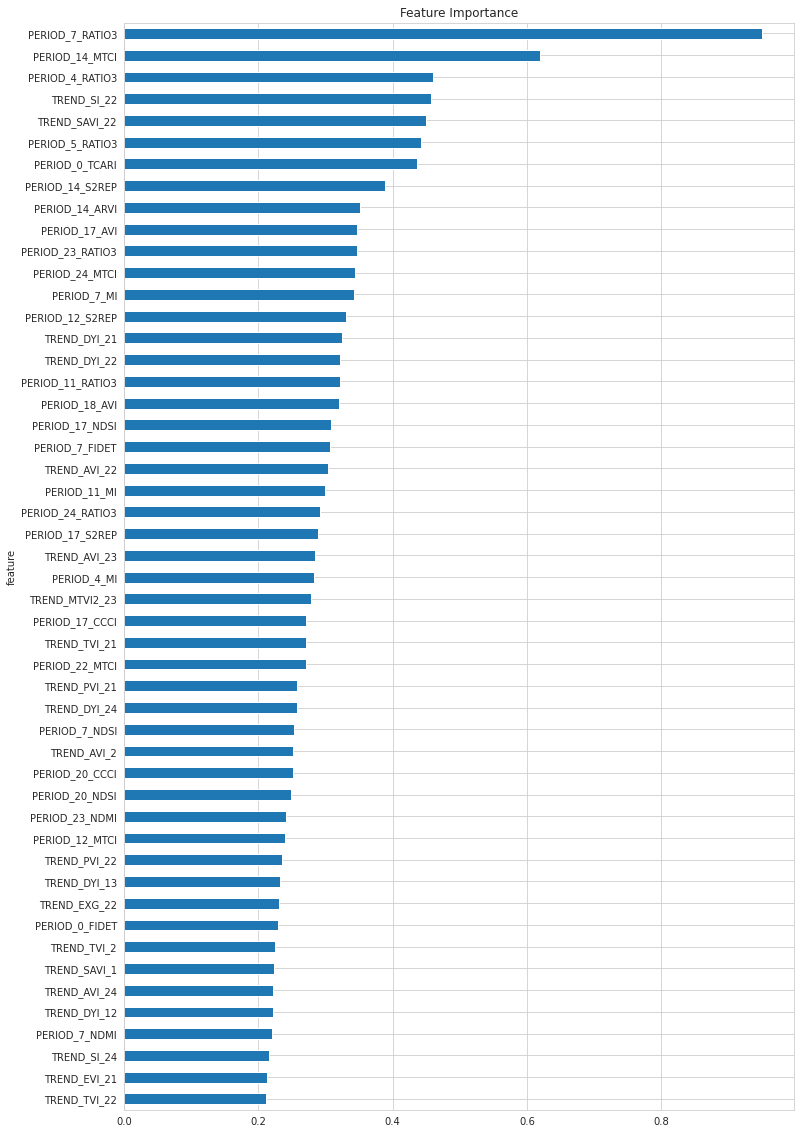

In [20]:
# Feature Importance plot
sns.set_style('whitegrid')
fi = feature_importance_df.groupby('feature')['importance'].mean()
fi.sort_values(ascending=False)[:50][::-1].plot(kind = 'barh', figsize=(12, 20), title = 'Feature Importance')
plt.show()

### CATBOOST- Month

In [21]:
%%time
# Select X and y features
X = m_train.copy()
y = target_month.copy()
tess = m_test.copy()

# Stratified Validation
folds = StratifiedKFold(n_splits = 10)

# Dataframe to store feature importance
feature_importance_df = pd.DataFrame()

# Lists to store predictions and losses
month_predictions = []
losses = []
for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]

  # Instantiate model
  model = CatBoostClassifier(n_estimators=20000, task_type='GPU', bagging_temperature=0.3)

  # Train model
  model.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=200,
            verbose = 1000,
            use_best_model = True)

  # Make predictions
  preds = model.predict_proba(tess)
  y_pred = model.predict_proba(X_test)

  # Append predictions and losses
  month_predictions.append(preds)
  loss = log_loss(y_test, y_pred)

  # Append feature importance per fold
  fold_importance_df = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': model.feature_importances_})
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

  # Print loss
  print(f'{i+1}:  {loss}\n')
  losses.append(loss)

print(f'Mean Loss: {np.mean(losses)}')

Learning rate set to 0.044117
0:	learn: 2.0912849	test: 2.0916832	best: 2.0916832 (0)	total: 47.3ms	remaining: 15m 46s
1000:	learn: 0.6560864	test: 0.7807595	best: 0.7807595 (1000)	total: 36.8s	remaining: 11m 38s
2000:	learn: 0.5060702	test: 0.7158105	best: 0.7158105 (2000)	total: 1m 12s	remaining: 10m 50s
3000:	learn: 0.4066880	test: 0.6802829	best: 0.6802829 (3000)	total: 1m 47s	remaining: 10m 9s
4000:	learn: 0.3337923	test: 0.6566113	best: 0.6566113 (4000)	total: 2m 22s	remaining: 9m 30s
5000:	learn: 0.2789892	test: 0.6408670	best: 0.6408670 (5000)	total: 2m 57s	remaining: 8m 52s
6000:	learn: 0.2357007	test: 0.6283188	best: 0.6283004 (5998)	total: 3m 32s	remaining: 8m 15s
7000:	learn: 0.2014479	test: 0.6185729	best: 0.6185550 (6996)	total: 4m 6s	remaining: 7m 38s
8000:	learn: 0.1728283	test: 0.6113196	best: 0.6113196 (8000)	total: 4m 41s	remaining: 7m 2s
9000:	learn: 0.1497588	test: 0.6057865	best: 0.6057865 (9000)	total: 5m 16s	remaining: 6m 26s
10000:	learn: 0.1300742	test: 0.6013

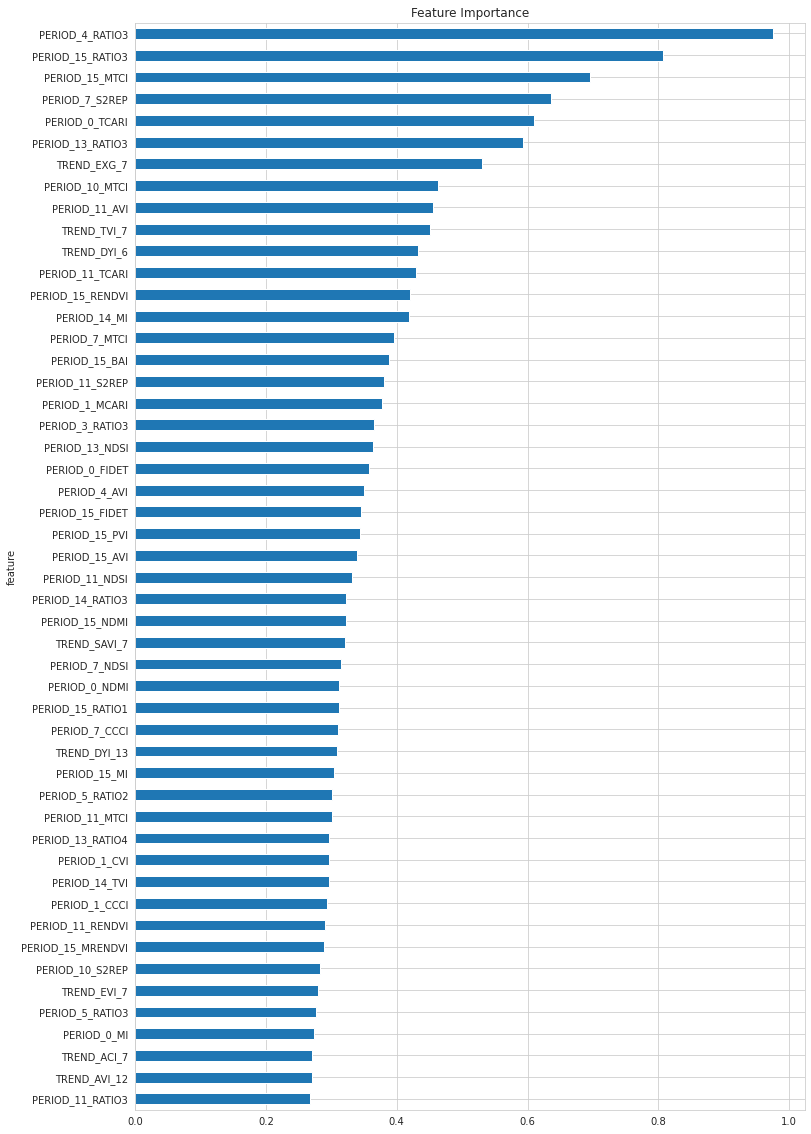

In [22]:
# Feature Importance plot
sns.set_style('whitegrid')
fi = feature_importance_df.groupby('feature')['importance'].mean()
fi.sort_values(ascending=False)[:50][::-1].plot(kind = 'barh', figsize=(12, 20), title = 'Feature Importance')
plt.show()

In [28]:
blend = (np.mean(season_predictions, 0) * 0.7) + (np.mean(month_predictions, 0) * 0.3)
sub_creator(blend, 'brainiac_catboost_models')